# [Unit 16 附錄A] MNIST 手寫數字辨識實戰 – CNN 基礎入門

**課程名稱**：化工資料科學與機器學習實務（CHE-AI-101）  
**教材定位**：選讀附錄，建議在 Unit16 主課程前閱讀

**本附錄目標**：
1.  **建立 CNN 模型**：使用 TensorFlow/Keras 建立卷積神經網路 (Convolutional Neural Network)。
2.  **影像前處理**：了解影像資料的正規化 (Normalization) 與維度調整 (Reshape)。
3.  **模型訓練與評估**：觀察 Accuracy 與 Loss 的學習曲線，並討論過擬合現象。
4.  **結果視覺化**：直觀地查看模型對手寫數字的辨識結果。

**資料集介紹**：
MNIST 手寫數字資料集（0–9），包含 60,000 張訓練影像與 10,000 張測試影像。
這在化工領域可類比為：
-   產品外觀檢測（瑕疵辨識）。
-   顯微影像中的顆粒或結晶型態分類。

**學習路徑**：
- **本附錄 (MNIST)**: CNN 基礎概念與實作
- **附錄B (Cats vs Dogs)**: 遷移學習實戰
- **Unit17 (NEU 鋼材缺陷)**: 工業影像檢測完整案例

---
# 0. 環境設定

In [8]:
# ========================================
# 載入必要的套件
# ========================================
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from pathlib import Path
import os
import sys
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")
try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

OUTPUT_DIR = 'outputs/P4_Unit16_MNIST_Results'
DATA_DIR = 'data/MNIST'
if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_4'
    OUTPUT_DIR = shortcut_path / OUTPUT_DIR
    DATA_DIR = shortcut_path / DATA_DIR
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / DATA_DIR

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ 工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 輸出目錄: {OUTPUT_DIR}")
print(f"✓ 數據目錄: {DATA_DIR}")

# ========================================
# 檢查 GPU 狀態
# ========================================
print(f"\nTensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ 偵測到 GPU：{gpus[0].name}")
    print("  （訓練速度將明顯快於僅用 CPU）")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("△ 未偵測到 GPU。")
    print("  訓練速度將使用 CPU（速度較慢但仍可完成）")

# ========================================
# 確認範例數據資料
# ========================================
print("\nMNIST 資料集已內建於keras.datasets")


✓ 偵測到 Local 環境

✓ 工作目錄: d:\MyGit\CHE-AI-COURSE\Part_4
✓ 輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_MNIST_Results
✓ 數據目錄: d:\MyGit\CHE-AI-COURSE\Part_4\data\MNIST

TensorFlow Version: 2.10.0
✓ 偵測到 GPU：/physical_device:GPU:0
  （訓練速度將明顯快於僅用 CPU）

MNIST 資料集已內建於keras.datasets


---
## 1. 資料載入與前處理 (Data Loading & Preprocessing)

我們使用 Keras 內建的 MNIST 資料集。
影像資料通常是 0~255 的整數，為了讓神經網路更容易收斂，我們需要將其正規化到 0~1 之間。
此外，CNN 的輸入通常需要包含「通道數 (Channel)」，因此我們需要將 (28, 28) 的影像 reshape 成 (28, 28, 1)。

In [ ]:
# 載入 MNIST 資料集
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

print(f"原始訓練集形狀: {train_images.shape}")
print(f"原始測試集形狀: {test_images.shape}")

# 正規化 (Normalization): 0-255 -> 0-1
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# Reshape: (28, 28) -> (28, 28, 1) 以符合 CNN 輸入格式 (Height, Width, Channels)
train_images = train_images.reshape((-1, 28, 28, 1))
test_images = test_images.reshape((-1, 28, 28, 1))

print("前處理後訓練集形狀:", train_images.shape)

原始訓練集形狀: (60000, 28, 28)
原始測試集形狀: (10000, 28, 28)
前處理後訓練集形狀: (60000, 28, 28, 1)


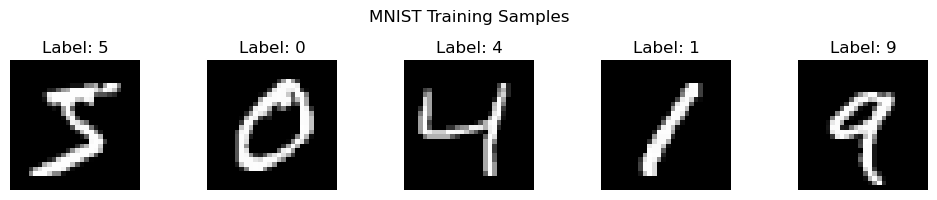

In [ ]:
# 視覺化前 5 張訓練影像
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_images[i].reshape(28, 28), cmap="gray")
    plt.title(f"Label: {train_labels[i]}")
    plt.axis("off")
plt.suptitle("MNIST Training Samples")
plt.tight_layout()
plt.show()

---
## 2. 建立 CNN 模型 (Build CNN Model)

我們將建立一個簡單的卷積神經網路，包含：
1.  **特徵提取層 (Feature Extraction)**：
    -   `Conv2D`：卷積層，負責提取影像特徵（如邊緣、紋理）。
    -   `MaxPooling2D`：池化層，負責降低維度並保留重要特徵。
2.  **分類層 (Classification Head)**：
    -   `Flatten`：將二維特徵圖展平為一維向量。
    -   `Dense`：全連接層，負責最後的分類決策。

In [4]:
model = models.Sequential()

# --- 特徵提取層 ---
# 第一層卷積：32 個 3x3 的濾波器
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# 第二層卷積：64 個 3x3 的濾波器
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))

# 第三層卷積
model.add(layers.Conv2D(64, (3, 3), activation="relu"))

# --- 分類層 ---
model.add(layers.Flatten()) # 展平
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax")) # 輸出 10 個類別的機率

# 顯示模型架構
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

---
## 3. 模型訓練 (Training)

我們使用 `adam` 優化器與 `sparse_categorical_crossentropy` 損失函數。
訓練過程中，我們會保留 10% 的資料作為驗證集 (Validation Set)，用來監控模型是否過擬合。

In [5]:
# 編譯模型
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# 設定訓練參數
epochs = 5
batch_size = 64

print(f"開始訓練模型 ({epochs} epochs)...")
history = model.fit(
    train_images,
    train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1, # 使用 10% 訓練資料做驗證
    verbose=1,
)
print("訓練完成！")

開始訓練模型 (5 epochs)...
Epoch 1/5
844/844 [==============================] - 5s 5ms/step - loss: 0.1954 - accuracy: 0.9396 - val_loss: 0.0660 - val_accuracy: 0.9797
Epoch 2/5
844/844 [==============================] - 4s 5ms/step - loss: 0.0549 - accuracy: 0.9837 - val_loss: 0.0398 - val_accuracy: 0.9883
Epoch 3/5
844/844 [==============================] - 4s 5ms/step - loss: 0.0380 - accuracy: 0.9879 - val_loss: 0.0395 - val_accuracy: 0.9892
Epoch 4/5
844/844 [==============================] - 4s 5ms/step - loss: 0.0293 - accuracy: 0.9905 - val_loss: 0.0416 - val_accuracy: 0.9887
Epoch 5/5
844/844 [==============================] - 4s 5ms/step - loss: 0.0239 - accuracy: 0.9925 - val_loss: 0.0302 - val_accuracy: 0.9908
訓練完成！


---
## 4. 學習曲線 (Learning Curves)

觀察 Accuracy 與 Loss 隨 Epoch 的變化，可以幫助我們判斷模型訓練狀況。
-   **正常**：Training 與 Validation 的 Accuracy 同步上升，Loss 同步下降。
-   **過擬合 (Overfitting)**：Training Accuracy 很高，但 Validation Accuracy 卡住甚至下降。

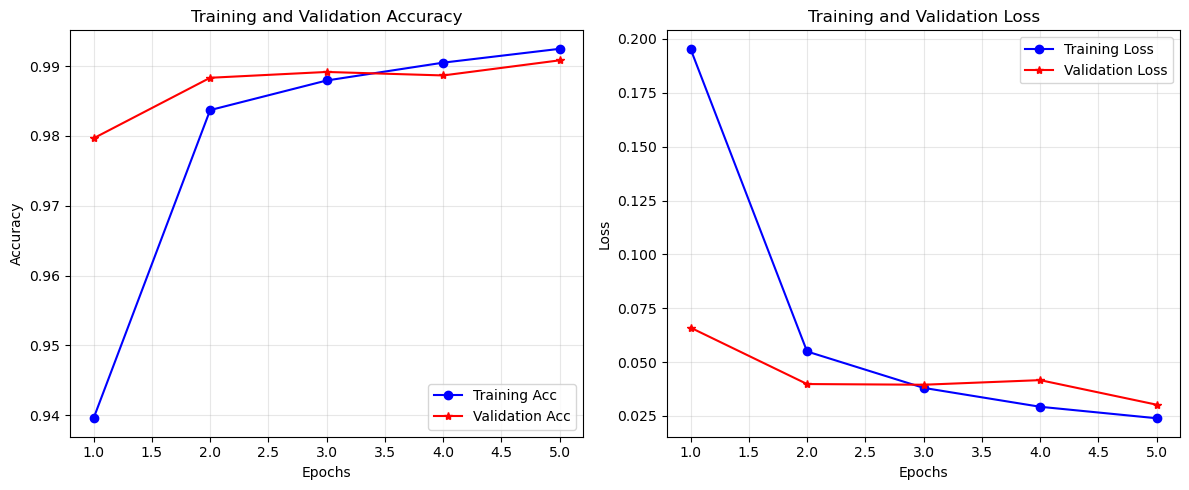

In [6]:
# 取得訓練歷史數據
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# 繪製 Accuracy 曲線
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, "bo-", label="Training Acc")
plt.plot(epochs_range, val_acc, "r*-", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# 繪製 Loss 曲線
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, "bo-", label="Training Loss")
plt.plot(epochs_range, val_loss, "r*-", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(str(OUTPUT_DIR / 'learning_curves.png'))
plt.show()

---
## 5. 預測結果展示 (Predictions)

最後，我們使用測試集來評估模型的最終表現，並視覺化部分預測結果。

313/313 - 1s - loss: 0.0288 - accuracy: 0.9909 - 835ms/epoch - 3ms/step

Test accuracy: 0.9908999800682068
313/313 [==============================] - 1s 2ms/step


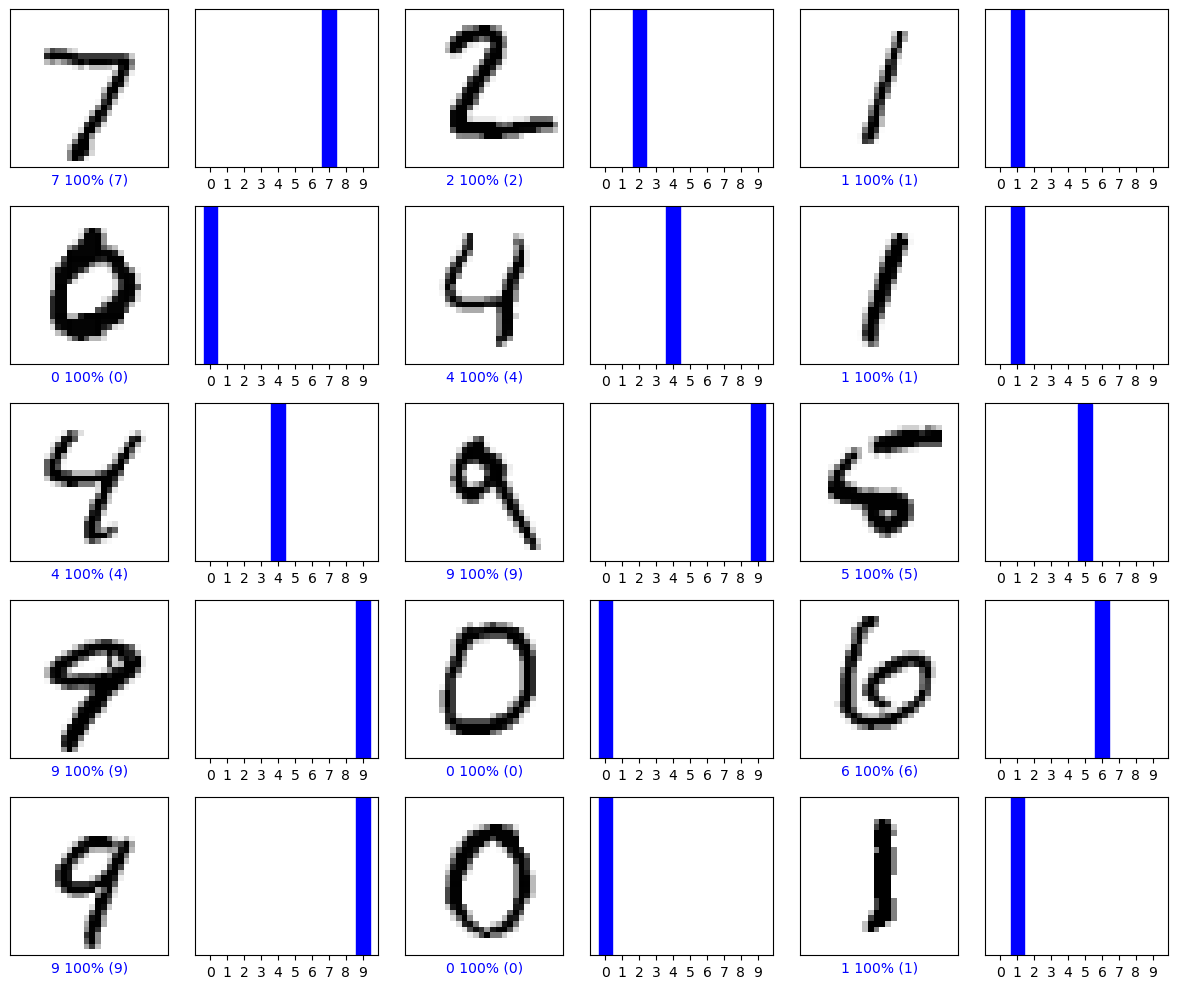

In [7]:
# 評估模型
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# 進行預測
predictions = model.predict(test_images)

# 視覺化預測結果
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img.reshape(28,28), cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

# 顯示前 15 張圖的預測結果
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()